In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import os
import glob
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support

### Comparison Results Outputs

In [ ]:
with open('/home/salipe/Desktop/datasets/ids_fasta.txt', 'r') as f:
    ids_fasta = [line.strip() for line in f.readlines()]

id_to_variant = {}
for seq_id in ids_fasta:
    id_to_variant[seq_id.split('|')[0]] = seq_id.split('|')[1]+"|"+seq_id.split('|')[2]

print(f"Criados {len(id_to_variant)} mapeamentos")
print("Primeiros 5 mapeamentos:")
for i, (key, value) in enumerate(id_to_variant.items()):
    if i < 5:
        print(f"{key}: {value}")

Criados 334956 mapeamentos
Primeiros 5 mapeamentos:
MZ083615.1: SARS-CoV-2|Alpha
OD911548.1: SARS-CoV-2|Alpha
MZ195292.1: SARS-CoV-2|Alpha
MZ152291.1: SARS-CoV-2|Alpha
MZ358479.1: SARS-CoV-2|Alpha


In [7]:
castor_results = '/home/salipe/Desktop/genomic-extractor/comparison_scripts/castor_results/bench_sars'
kevolve_results = '/home/salipe/Desktop/genomic-extractor/comparison_scripts/kevolve_results/bench_sars'


results = []
confusion_matrices = []

# Percorre todos os arquivos CSV na pasta
for filepath in glob.glob(os.path.join(kevolve_results, '*.csv')):
    df = pd.read_csv(filepath)  # se for separado por tabs, use sep='\t'
    
    # Extrai y_true a partir da coluna 'id' (classe após o segundo '|')
    df['y_true'] = df['id'].str.split('|').str[2]
    # df['y_true'] = df['id'].map(id_to_variant)
    y_true = df['y_true']
    y_pred = df['y_pred']

    
    # Lista de variantes (classes) presentes
    labels = sorted(pd.unique(pd.concat([pd.Series(y_true), pd.Series(y_pred)])))
    
    # Calcula matriz de confusão para este arquivo
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    confusion_matrices.append(cm)
    
    p_cls, r_cls, f1_cls, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )
    
    # Calcula métricas macro (média das métricas por classe)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    
    # Monta dicionário para este arquivo
    row = {
        'file': os.path.basename(filepath),
        'precision_macro': p_macro,
        'recall_macro': r_macro,
        'f1_macro': f1_macro
    }
    
    # Adiciona as métricas por classe
    for lbl, p, r, f1 in zip(labels, p_cls, r_cls, f1_cls):
        row[f'precision_{lbl}'] = p
        row[f'recall_{lbl}'] = r
        row[f'f1_{lbl}'] = f1
    
    results.append(row)

# DataFrame com resultados individuais
results_df = pd.DataFrame(results)


# Estatísticas globais (média e desvio padrão) das métricas macro
summary = results_df[['precision_macro', 'recall_macro', 'f1_macro']].agg(['mean', 'std']).T
summary = summary.round(4)

# Salva resultados em CSV
# results_df.to_csv('model_metrics_per_file.csv', index=False)
# summary.to_csv('macro_metrics_summary.csv')

# Exibe um preview
print("Resultados por arquivo:")
print(results_df.head(), end='\n\n')
print("Média e desvio padrão das métricas macro:")
print(summary)




Resultados por arquivo:
          file  precision_macro  recall_macro  f1_macro  precision_Alpha  \
0  pred_32.csv         0.012986      0.108448  0.021575         0.008317   
1  pred_35.csv         0.146553      0.031584  0.050154         0.450468   
2  pred_98.csv         0.014112      0.100073  0.011438         0.000000   
3  pred_49.csv         0.166056      0.199666  0.101209         0.919186   
4  pred_96.csv         0.071680      0.100956  0.011300         0.000000   

   recall_Alpha  f1_Alpha  precision_Beta  recall_Beta   f1_Beta  ...  \
0      0.000074  0.000147        0.000000     0.000000  0.000000  ...   
1      0.042610  0.077856        0.000000     0.000000  0.000000  ...   
2      0.000000  0.000000        0.000000     0.000000  0.000000  ...   
3      0.950012  0.934345        0.000556     0.004950  0.000999  ...   
4      0.000000  0.000000        0.000050     0.009901  0.000100  ...   

    f1_Iota  precision_Kappa  recall_Kappa  f1_Kappa  precision_Lambda  \
0  0.2

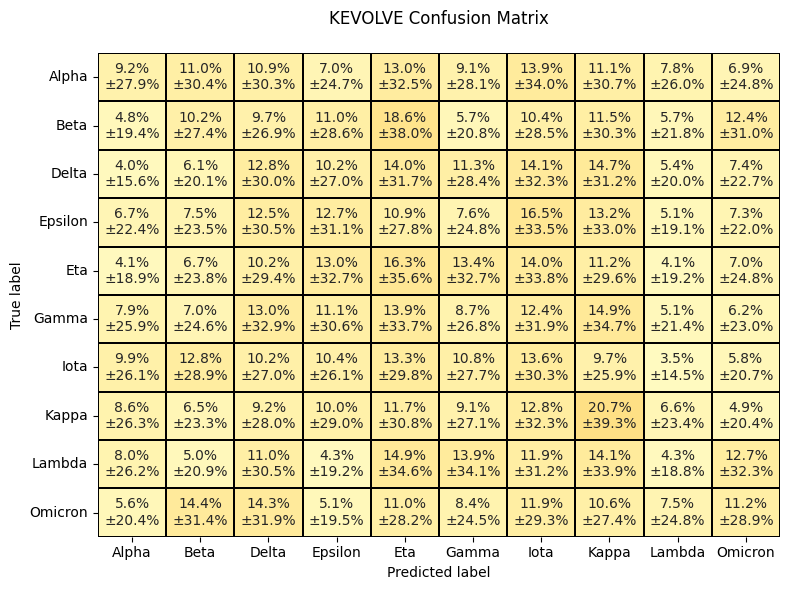

In [9]:
# ===== MATRIZ DE CONFUSÃO COM DESVIO PADRÃO =====
covlabels = ["Alpha", "Beta", "Delta", "Epsilon", "Eta", "Gamma", "Iota", "Kappa", "Lambda", "Omicron"]
# Converte as matrizes para numpy array 3D (n_files, n_classes, n_classes)
confusion_matrices = np.array(confusion_matrices)

# Calcula média e desvio padrão das matrizes de confusão
cm_mean = np.mean(confusion_matrices, axis=0)
cm_std = np.std(confusion_matrices, axis=0)

# Cria DataFrames para as matrizes
cm_mean_df = pd.DataFrame(cm_mean, index=labels, columns=labels)
cm_std_df = pd.DataFrame(cm_std, index=labels, columns=labels)

# Cria matriz combinada (média ± desvio padrão)
cm_combined = pd.DataFrame(index=labels, columns=labels)
for i, true_label in enumerate(labels):
    for j, pred_label in enumerate(labels):
        mean_val = cm_mean[i, j]
        std_val = cm_std[i, j]
        cm_combined.loc[true_label, pred_label] = f"{mean_val:.1f} ± {std_val:.1f}"

# ===== VISUALIZAÇÃO =====

# Normaliza a matriz de confusão por linha (divide cada linha pela soma da linha)
# Isso converte contagens absolutas em proporções/porcentagens por classe verdadeira
cm_normalized = cm_mean / cm_mean.sum(axis=1, keepdims=True)
cm_normalized_df = pd.DataFrame(cm_normalized, index=labels, columns=labels)

# Calcula desvio padrão normalizado também
cm_matrices_normalized = np.array([cm / cm.sum(axis=1, keepdims=True) for cm in confusion_matrices])
cm_std_normalized = np.std(cm_matrices_normalized, axis=0)

# Cria anotações combinadas com valores normalizados (média ± desvio padrão)
annotations = np.empty_like(cm_normalized, dtype=object)
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        mean_val = cm_normalized[i, j]
        std_val = cm_std_normalized[i, j]
        # Mostra como porcentagem
        annotations[i, j] = f"{mean_val*100:.1f}%\n±{std_val*100:.1f}%"

# Criar figura única
fig, ax = plt.subplots(figsize=(8, 6))

# Heatmap com matriz normalizada (valores entre 0 e 1)
sns.heatmap(ax=ax,
            data=cm_normalized_df,
            annot=annotations,
            fmt="",
            cmap='YlOrRd',
            linecolor="black",
            linewidths=.1,
            cbar=False,
            vmin=0,
            vmax=1)

ax.set_xticklabels(covlabels)
ax.set_title("KEVOLVE Confusion Matrix\n")
# X and Y Labels
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")

# Y ticks labels
ax.yaxis.set_ticklabels(covlabels, rotation=0)

plt.tight_layout()
plt.savefig("kevolve_cm.pdf", dpi=300, format="pdf", bbox_inches="tight")
plt.show()


In [2]:
# Your confusion matrix data
covlabels = ["Alpha", "Beta", "Delta", "Epsilon", "Eta", "Gamma", "Iota", "Kappa", "Lambda", "Omicron"]
denvlabels = ["Type1", "Type2", "Type3", "Type4"]
data_str = """
[105885 0 314 0 0 0 5 0 0 0; 0 603 3 0 0 0 0 0 0 0; 0 0 14585 0 0 0 0 0 0 0; 0 0 41 586 0 0 0 0 0 0; 0 0 176 130 7734 0 0 0 0 0; 0 0 0 0 0 339 0 0 0 0; 4 0 542 0 0 0 8760 13 0 0; 0 0 0 0 0 0 0 38 0 0; 0 93 45 0 0 0 0 0 19047 0; 1496 0 20 0 0 0 0 0 1 173606]
"""

# Convert string data to numpy array
data_str = data_str.strip('[]\n ')
rows = data_str.split(';')
conf_matrix = np.array([list(map(int, row.split())) for row in rows])



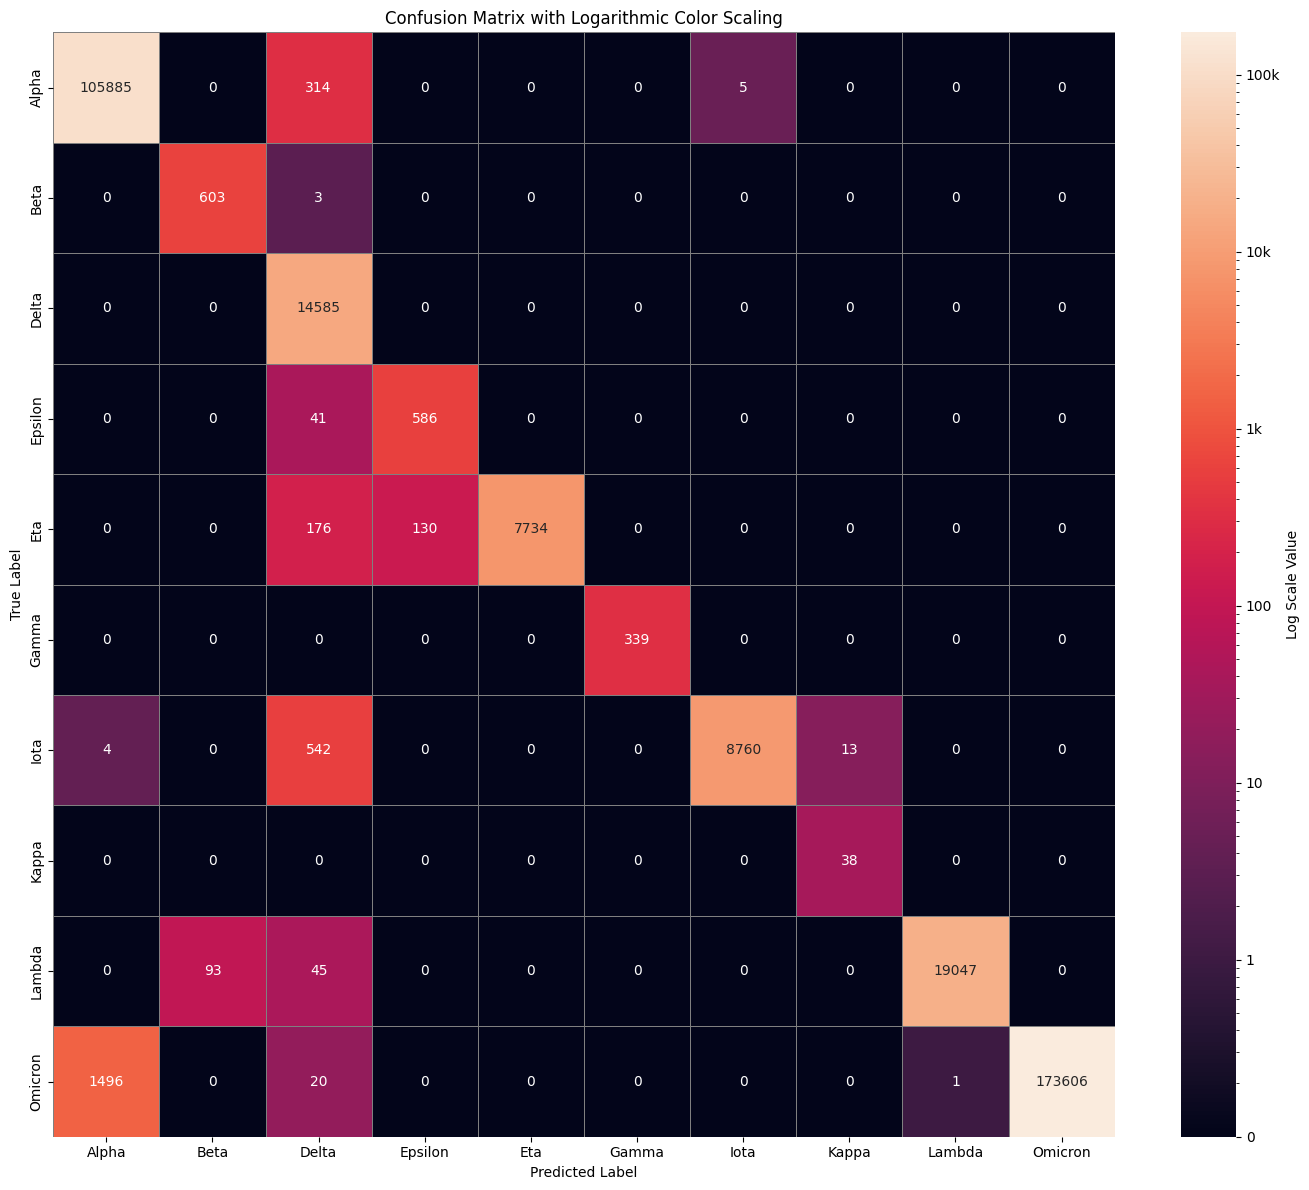

In [7]:
conf_matrix_viz = conf_matrix.astype(float)
conf_matrix_viz[conf_matrix_viz == 0] = 0.1

plt.figure(figsize=(14, 12))
ax = sns.heatmap(conf_matrix_viz, 
                 annot=conf_matrix,  # Show original values in annotations
                 fmt='d',
                 cmap='rocket',
                 norm=LogNorm(vmin=0.1, vmax=conf_matrix.max()),
                 linewidths=0.5,
                 linecolor='grey',
                 cbar_kws={'label': 'Log Scale Value'},
                 xticklabels=covlabels,
                 yticklabels=covlabels)

# Customize colorbar ticks
cbar = ax.collections[0].colorbar
tick_values = [0.1, 1, 10, 100, 1000, 10000, 100000]
cbar.set_ticks(tick_values)
cbar.set_ticklabels(['0', '1', '10', '100', '1k', '10k', '100k'])

ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix with Logarithmic Color Scaling')
plt.tight_layout()
plt.show()